In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.io import wavfile
import os.path
import IPython.display
import seaborn as sns
import librosa
import librosa.display
import soundfile

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras import utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv1D, MaxPooling1D, Flatten, BatchNormalization
from keras import optimizers

import warnings

In [9]:
image_dir = Path('Crema')

In [10]:
filepaths = list(image_dir.glob(r'**/*.wav'))


In [11]:
labels = list(map(lambda x: os.path.split(x)[1].split('_')[2], filepaths))


In [12]:
set(labels)


{'ANG', 'DIS', 'FEA', 'HAP', 'NEU', 'SAD'}

In [13]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

audio_df = pd.concat([filepaths, labels], axis=1)
audio_df

,Filepath,Label
0,Crema\1001_DFA_ANG_XX.wav,ANG
1,Crema\1001_DFA_DIS_XX.wav,DIS
2,Crema\1001_DFA_FEA_XX.wav,FEA
3,Crema\1001_DFA_HAP_XX.wav,HAP
4,Crema\1001_DFA_NEU_XX.wav,NEU
...,...,...
7437,Crema\1091_WSI_DIS_XX.wav,DIS
7438,Crema\1091_WSI_FEA_XX.wav,FEA
7439,Crema\1091_WSI_HAP_XX.wav,HAP
7440,Crema\1091_WSI_NEU_XX.wav,NEU


<Axes: xlabel='Label', ylabel='Count'>

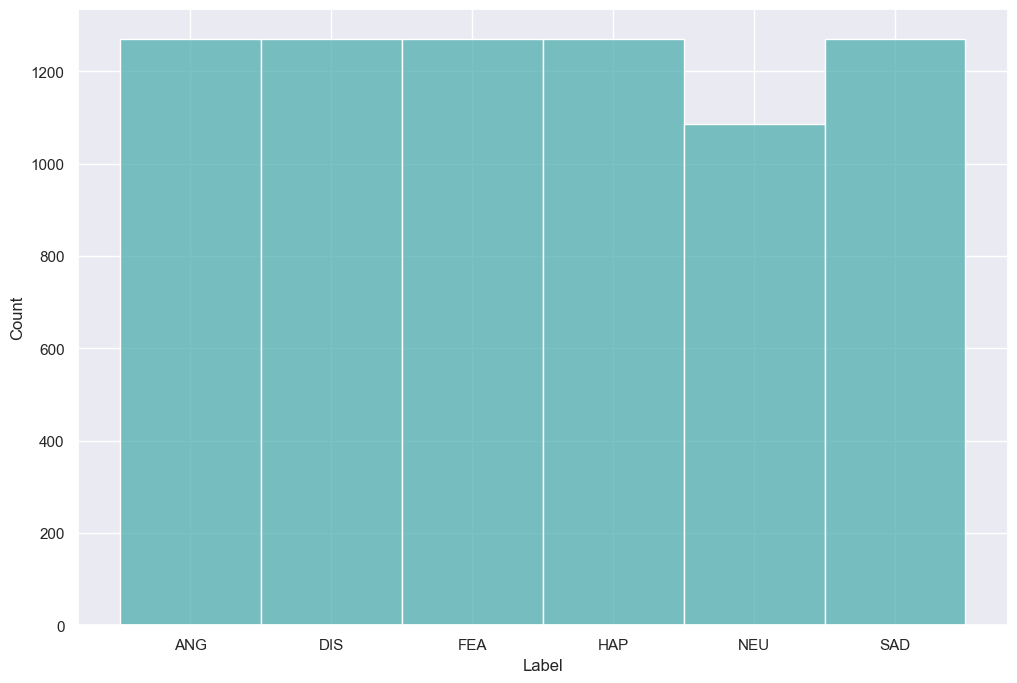

In [14]:
sns.set(rc={'figure.figsize':(12,8)})
sns.set_style('darkgrid')
sns.histplot(labels, color='#4FAEB0')

In [15]:
audio_arrays = []

for i in audio_df['Filepath']:
    x, sr = librosa.load(i, sr=44100)
    audio_arrays.append(x)
    
audio_df['Arrays'] = audio_arrays

In [16]:
audio_df

,Filepath,Label,Arrays
0,Crema\1001_DFA_ANG_XX.wav,ANG,"[6.9185524e-10, 8.411215e-10, 5.0900356e-10, 4..."
1,Crema\1001_DFA_DIS_XX.wav,DIS,"[0.00083351025, 0.0011382565, 0.0012377766, 0...."
2,Crema\1001_DFA_FEA_XX.wav,FEA,"[0.007539533, 0.009629492, 0.008980679, 0.0084..."
3,Crema\1001_DFA_HAP_XX.wav,HAP,"[-0.0039882455, -0.004723385, -0.0038926, -0.0..."
4,Crema\1001_DFA_NEU_XX.wav,NEU,"[0.0022234665, 0.002518577, 0.001856927, 0.001..."
...,...,...,...
7437,Crema\1091_WSI_DIS_XX.wav,DIS,"[0.0009247182, 0.001315127, 0.0013675159, 0.00..."
7438,Crema\1091_WSI_FEA_XX.wav,FEA,"[-0.0066004125, -0.008246948, -0.0073625883, -..."
7439,Crema\1091_WSI_HAP_XX.wav,HAP,"[-0.0020721315, -0.0024467015, -0.0020733473, ..."
7440,Crema\1091_WSI_NEU_XX.wav,NEU,"[-0.00152146, -0.0017805105, -0.0013755669, -0..."


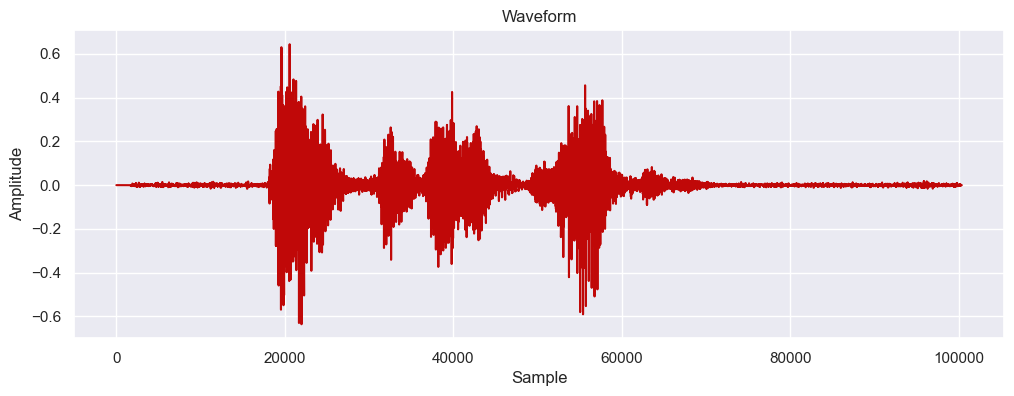

In [17]:
angfile = audio_df[audio_df['Label'] == 'ANG']['Filepath']
angarray = audio_df[audio_df['Label'] == 'ANG']['Arrays']

plt.figure(figsize=(12, 4))
plt.plot(angarray.iloc[0], color='#C00808')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Waveform')
plt.show()

IPython.display.Audio(angfile.iloc[0])

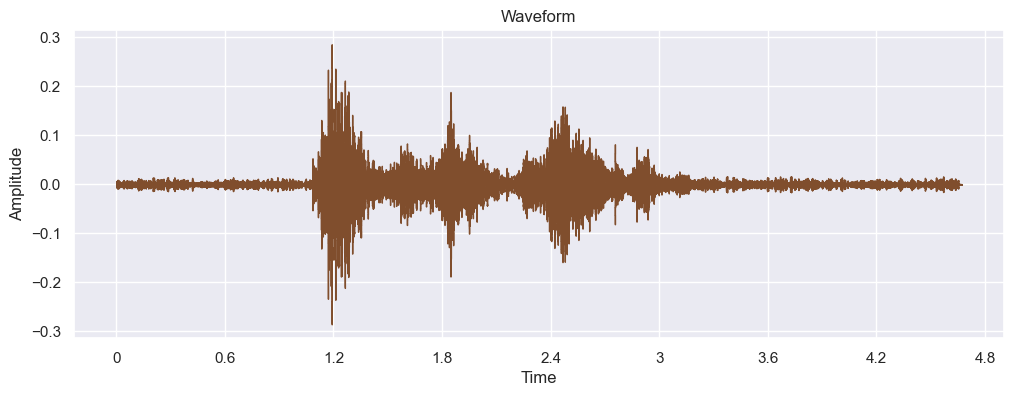

In [18]:
disfile = audio_df[audio_df['Label'] == 'DIS']['Filepath']
disarray = audio_df[audio_df['Label'] == 'DIS']['Arrays']

plt.figure(figsize=(12, 4))
librosa.display.waveshow(disarray.iloc[0], color='#804E2D')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Waveform')
plt.show()

IPython.display.Audio(disfile.iloc[0])

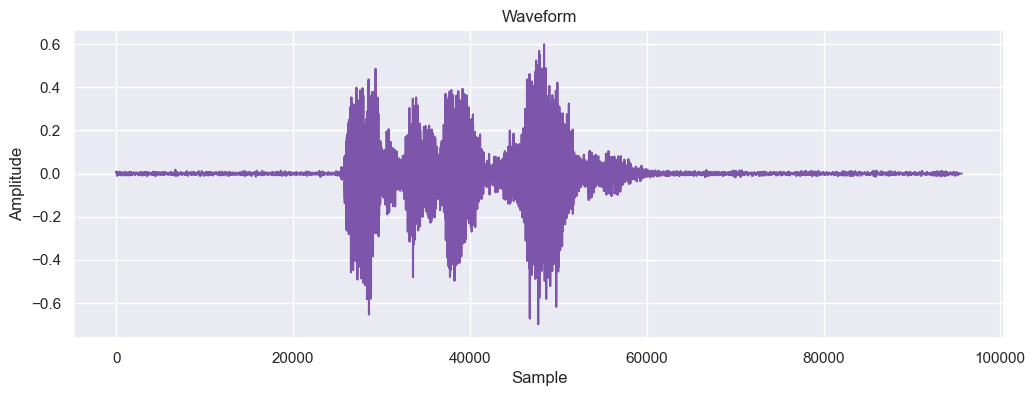

In [19]:
feafile = audio_df[audio_df['Label'] == 'FEA']['Filepath']
feaarray = audio_df[audio_df['Label'] == 'FEA']['Arrays']

plt.figure(figsize=(12, 4))
plt.plot(feaarray.iloc[0], color='#7D55AA')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Waveform')
plt.show()

IPython.display.Audio(feafile.iloc[0])

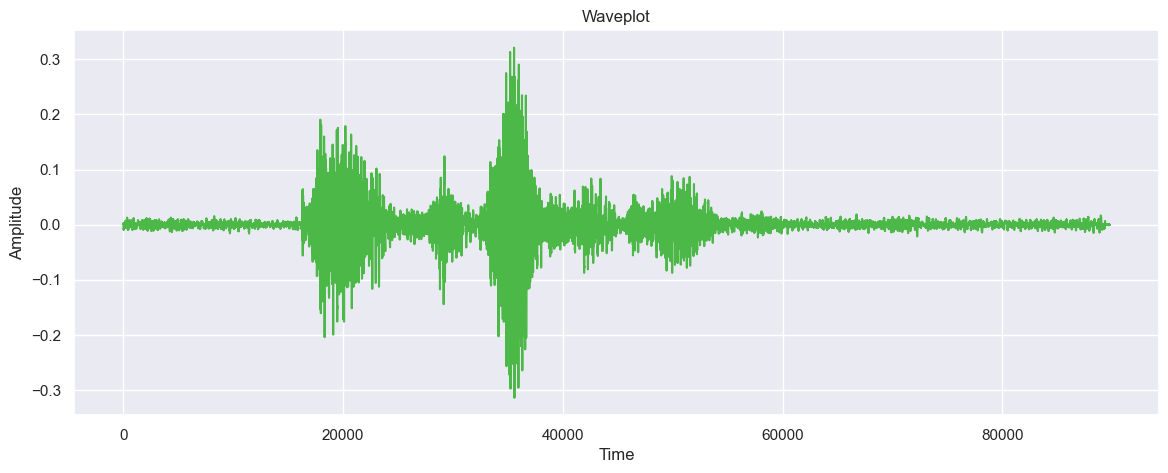

In [20]:
neuarray = audio_df[audio_df['Label'] == 'NEU']['Arrays']

plt.figure(figsize=(14, 5))
plt.plot(neuarray.iloc[0], color='#4CB847')
plt.title('Waveplot')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

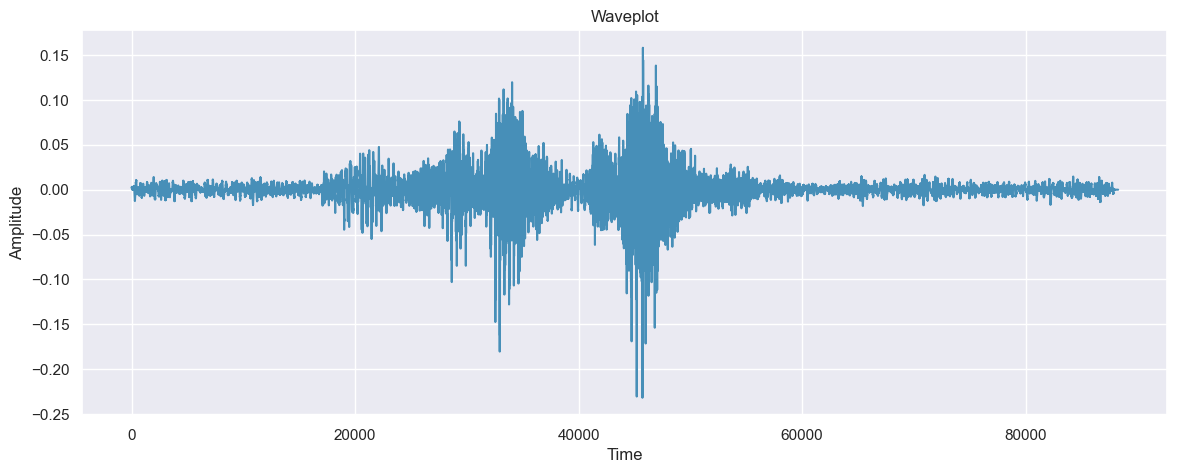

In [21]:
sadarray = audio_df[audio_df['Label'] == 'SAD']['Arrays']

plt.figure(figsize=(14, 5))
plt.plot(sadarray.iloc[0], color='#478FB8')
plt.title('Waveplot')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

In [22]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

In [23]:
def extract_features(data):
    # Zero Crossing Rate
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result = np.hstack((result, zcr))

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr, n_fft=200).T, axis=0)
    result = np.hstack((result, chroma_stft))     

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sr, n_fft=200).T, axis=0)
    result = np.hstack((result, mfcc))

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sr, n_fft=200).T, axis=0)
    result = np.hstack((result, mel))
    
    # Tonnetz
    tonnetz = np.mean(librosa.feature.tonnetz(y=data, sr=sr).T, axis=0)
    result = np.hstack((result, tonnetz))
    
    return result

In [24]:
def get_features(data):
    result = []
    
    # without augmentation
    res1 = extract_features(data)
    result.append(res1)
    
    # with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result.append(res2)
    
    # with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sr)
    res3 = extract_features(data_stretch_pitch)
    result.append(res3)
    
    return result

In [25]:
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)